# Data Handling with Pandas: A Case Study Using BVMT Historical Prices

Working with real-world financial data often requires extensive preprocessing before any analysis can take place. This tutorial provides a step-by-step guide to cleaning historical stock price data from the Bourse de Tunis (BVMT) using Pandas. It is intended for finance students, analysts, and practitioners who want to demonstrate practical data-handling skills in Python.

In a small market like the Tunisian stock market, it is particularly important to handle data carefully. Losing too many stocks during cleaning can severely reduce your sample and limit the reliability of subsequent analyses. Efficient data handling helps preserve as much information as possible, which is critical because this cleaned data will be used in all financial modeling tasks, such as:

- VAR and CVaR analysis
- Portfolio simulation
- Multifactor model testing

Historical data can be downloaded directly from the [BVMT website](https://www.bvmt.com.tn/en-gb/content/historical-data)
. In this tutorial, we use the 2018 daily price file as an illustrative example.

![Raw BVMT sample](raw_data.png)

The BVMT dataset is provided as a **fixed-width** text file, a format that is not immediately compatible with most analytical tools and programming environments. As a result, the first step is to parse and structure the raw file into a usable tabular format. The following sections walk through this process in a clear and reproducible way.

## Loading BVMT Data into Pandas

We start by importing the necessary dependencies. Using the **pandas.read_fwf()** function, we can parse the fixed-width text file provided by the BVMT and convert it into a clean tabular structure. This allows us to load the raw .txt file directly into a DataFrame without manually splitting columns.

In [10]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_fwf('histo_cotation_2018.txt')
df.head()

,SEANCE,C_GR_RLC,CODE_VAL,LIB_VAL,COURS_REF,COURS_VEILLE,OUVERTURE,DERNIER_COURS,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRAN,CAPITAUX,I
0,--------,----------,------------------------,------------------,----------,------------,----------,-------------,----------,----------,----------,-----------------,----------,----------,-
1,02/01/18,11,725001,ADWYA,"5,35","5,35","5,25","5,39","5,39","5,25","5,39",2926,7,"15635,5",NaN
2,02/01/18,11,340005,AMEN BANK,"24,35","24,35","24,38",24,24,24,"24,38",1519,12,36918,NaN
3,02/01/18,11,730001,ARTES,"6,27","6,2","6,27","6,1","6,1","6,09","6,27",35875,67,"219020,05",NaN
4,02/01/18,11,714001,ASSAD,9,9,0,0,9,0,0,0,0,NaN,NaN


Next, we perform the initial cleaning steps. We begin by removing the first row, which contains header information that is not part of the actual dataset. After that, we set the *SEANCE* column as our index and convert it to a **datetime64** type using **pandas.to_datetime()**.

Converting the index to a proper datetime format is useful because it allows Pandas to recognize the column as a time series. This enables powerful date-based operations such as filtering, resampling, merging on dates, and computing returns over time.

In [12]:
df = df.drop(0, axis=0).set_index('SEANCE')
df.head(2)

,C_GR_RLC,CODE_VAL,LIB_VAL,COURS_REF,COURS_VEILLE,OUVERTURE,DERNIER_COURS,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRAN,CAPITAUX,I
SEANCE,,,,,,,,,,,,,,
02/01/18,11,725001,ADWYA,"5,35","5,35","5,25","5,39","5,39","5,25","5,39",2926,7,"15635,5",NaN
02/01/18,11,340005,AMEN BANK,"24,35","24,35","24,38",24,24,24,"24,38",1519,12,36918,NaN


Note that in this specific dataset, the BVMT provides dates in the dd/mm/yy format. This format can change from one year to another, so it must be checked each time you download a new file. To ensure accurate parsing, we pass the date format explicitly to pandas.to_datetime() using the format="%d/%m/%y" argument.

(For details on format codes (e.g., %d, %m, %Y), refer to Python’s datetime.strptime documentation, which lists all supported date and time format specifiers.)

This prevents misinterpretation of day and month fields and guarantees consistent conversion to datetime64.

In [13]:
df.index = pd.to_datetime(df.index, format="%d/%m/%y")
df.head(2)

,C_GR_RLC,CODE_VAL,LIB_VAL,COURS_REF,COURS_VEILLE,OUVERTURE,DERNIER_COURS,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRAN,CAPITAUX,I
SEANCE,,,,,,,,,,,,,,
2018-01-02,11,725001,ADWYA,"5,35","5,35","5,25","5,39","5,39","5,25","5,39",2926,7,"15635,5",NaN
2018-01-02,11,340005,AMEN BANK,"24,35","24,35","24,38",24,24,24,"24,38",1519,12,36918,NaN


In [14]:
df.index

DatetimeIndex(['2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-02', '2018-01-02',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='SEANCE', length=74594, freq=None)

In [15]:
df.columns

Index(['C_GR_RLC', 'CODE_VAL', 'LIB_VAL', 'COURS_REF', 'COURS_VEILLE',
       'OUVERTURE', 'DERNIER_COURS', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT',
       'QUANTITE_NEGOCIEE', 'NB_TRAN', 'CAPITAUX', 'I'],
      dtype='object')

Before proceeding, it is useful to briefly describe a few columns from the dataset. Most variables are self-explanatory, but some require clarification:
- "C_GR_RLC" indicates the cotation group of each stock. For example, 11 corresponds to continuous trading (continu), 12 to fixing, and so on. For a full list of codes and their meaning, refer to the official BVMT documentation.
- "CODE_VAL" contains a truncated version of each stock’s ISIN. For instance, the ISIN of Amen Bank is TN000**340005**8, but the dataset only includes the substring 340005. This is important to keep in mind, especially when working with multi-year datasets or when merging multiple files. The reporting format is not always consistent from one year to another, so additional preprocessing may be necessary to ensure proper alignment across datasets.

From personal experience, CODE_VAL is the most consistent column across multiple years data. Therefore, it is recommended to create a dictionary using CODE_VAL as keys and stock tickers as values. This approach standardizes access to stock data across different datasets and simplifies multi-year analysis.

In [17]:
stocks = pd.read_csv('stocks.csv')
stocks_dict = dict(zip(stocks['ISIN'], stocks['VALEUR']))
stocks_dict

{725001: 'ADWYA',
 750001: 'AETECH',
 230035: 'AIR LIQUIDE TSIE',
 380070: 'ALKIMIA',
 340005: 'AMEN BANK',
 150085: 'AMS',
 730001: 'ARTES',
 714001: 'ASSAD',
 300045: 'ASTREE',
 360035: 'ATB',
 774001: 'ATELIER MEUBLE INT',
 470010: 'ATL',
 160015: 'ATTIJARI BANK',
 661001: 'ATTIJARI LEASING',
 758001: 'BEST LEASE',
 190060: 'BH',
 655001: 'BH ASSURANCE',
 672004: 'BH LEASING',
 180045: 'BIAT',
 310060: 'BNA',
 220005: 'BT',
 130055: 'BTE (ADP)',
 740001: 'CARTHAGE CEMENT',
 759001: 'CELLCOM',
 764001: 'CEREALIS',
 420085: 'CIL',
 735001: 'CIMENTS DE BIZERTE',
 755001: 'CITY CARS',
 767001: 'DELICE HOLDING',
 330090: 'ELBENE INDUSTRIE',
 665001: 'ELECTROSTAR',
 741001: 'ENNAKL AUTOMOBILES',
 721001: 'ESSOUKNA',
 757001: 'EURO-CYCLES',
 713001: 'GIF-FILTER',
 731013: 'HANNIBAL LEASE',
 749001: 'HEXABYTE',
 320075: 'ICF',
 751001: 'LAND OR',
 644001: 'MAGASIN GENERAL',
 766001: 'MAGHREB INTERN PUB',
 100010: 'MONOPRIX',
 762001: 'MPBS',
 754001: 'NEW BODY LINE',
 770001: 'OFFICEPLAST',

Since listed companies may change their names, merge with other companies, or be delisted, it is always safer to work with the ISIN code or a consistent subset like CODE_VAL. This ensures that your analysis remains accurate and stable over time, even when company identifiers in the dataset change.

# Investigating the dataset

It is always important to develop intuition when working with data and to ask the right questions. A good habit is to start by examining the dataset’s structure, including the data types of each column, as this helps identify potential issues early, such as numerical columns stored as strings, missing values, or inconsistent formats. This step lays the foundation for effective cleaning and analysis.

In [24]:
df.shape[0] #number of rows

74594

In [25]:
df.shape[1] #number of columns

14

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74594 entries, 2018-01-02 to 2018-12-31
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   C_GR_RLC           74594 non-null  object
 1   CODE_VAL           74594 non-null  object
 2   LIB_VAL            74594 non-null  object
 3   COURS_REF          74594 non-null  object
 4   COURS_VEILLE       74594 non-null  object
 5   OUVERTURE          74594 non-null  object
 6   DERNIER_COURS      74594 non-null  object
 7   CLOTURE            74594 non-null  object
 8   PLUS_BAS           74594 non-null  object
 9   PLUS_HAUT          74594 non-null  object
 10  QUANTITE_NEGOCIEE  74594 non-null  object
 11  NB_TRAN            74594 non-null  object
 12  CAPITAUX           21423 non-null  object
 13  I                  2031 non-null   object
dtypes: object(14)
memory usage: 8.5+ MB


To illustrate a common data handling issue, let us first attempt to convert the Close price column (CLOTURE) to a float.

In [32]:
df['CLOTURE'] = df['CLOTURE'].astype(np.float64)

ValueError: could not convert string to float: '5,39'

As expected, this raises a **ValueError**. Investigating the data, we notice that decimal numbers in the BVMT dataset use a comma (,) instead of a period (.), which is the standard in numerical computations.

In [33]:
df['CLOTURE']

SEANCE
2018-01-02    5,39
2018-01-02      24
2018-01-02     6,1
2018-01-02       9
2018-01-02    4,18
              ... 
2018-12-31     ,36
2018-12-31      ,6
2018-12-31    2,35
2018-12-31    2,04
2018-12-31     1,2
Name: CLOTURE, Length: 74594, dtype: object

The correct approach is to first replace all commas with periods, and then convert the CLOTURE column to the float data type. This ensures that numerical operations, such as calculating returns (which we will cover shortly) or performing statistical analysis, work correctly.

In [36]:
df['CLOTURE'] = df['CLOTURE'].str.replace(',','.')
df['CLOTURE'] = df['CLOTURE'].astype(np.float64)

In [37]:
df['CLOTURE']

SEANCE
2018-01-02     5.39
2018-01-02    24.00
2018-01-02     6.10
2018-01-02     9.00
2018-01-02     4.18
              ...  
2018-12-31     0.36
2018-12-31     0.60
2018-12-31     2.35
2018-12-31     2.04
2018-12-31     1.20
Name: CLOTURE, Length: 74594, dtype: float64

In [38]:
df['CLOTURE'].dtype

dtype('float64')

This example highlights the importance of carefully inspecting your data before performing any calculations or modeling. Taking the time to understand the dataset and identify potential issues can save a significant amount of time and effort that would otherwise be spent debugging errors later.

## Extracting daily prices from BVMT dataset

Depending on your analysis goals, you may choose to work with any set of columns or features. For the sake of simplicity in this tutorial, we will focus exclusively on the daily price columns. This allows us to demonstrate key data handling techniques without unnecessary complexity.

In [48]:
cols = ['CODE_VAL', 'CLOTURE'] # columns that we will use
prices = df[cols].copy() # creating a copy of the original dataframe, good habit to save the original one intact from any changes we will make

In [49]:
prices.head()

,CODE_VAL,CLOTURE
SEANCE,,
2018-01-02,725001,5.39
2018-01-02,340005,24.00
2018-01-02,730001,6.10
2018-01-02,714001,9.00
2018-01-02,360035,4.18


In [50]:
prices.columns = ['ISIN', 'CLOSE'] # renaming the columns 

If you have ever downloaded historical data from Yahoo Finance or other platforms, you have probably noticed that these datasets are typically indexed by time, with stock tickers as columns and the values representing the closing prices.

Our BVMT dataset is almost in this format, but not quite. To get it into the standard layout that most analysts are used to, we will perform a simple pivot operation. This will reorganize the data so that each column corresponds to a stock ticker (ISIN in our case), the rows are indexed by date, and the values represent the closing prices.

In [51]:
prices = prices.pivot(columns='ISIN', values='CLOSE')
prices.head()

ISIN,100010,100011,100012,100013,100014,110025,110028,110029,110030,110031,...,769001,770001,770003,772001,772002,772003,773001,774001,774002,779001
SEANCE,,,,,,,,,,,,,,,,,,,,,
2018-01-02,11.60,4.07,9.42,3.07,2.36,19.40,26.88,19.42,46.24,30.83,...,2.45,3.20,0.01,7.85,1.18,0.65,4.28,2.49,0.25,NaN
2018-01-03,11.60,4.13,9.56,3.00,2.40,19.88,26.40,19.07,45.41,30.27,...,2.46,3.05,0.81,8.00,1.19,0.66,4.27,2.49,0.25,NaN
2018-01-04,11.50,4.13,9.56,3.12,2.40,19.78,26.98,19.49,46.40,30.94,...,2.60,2.87,0.78,7.98,1.23,0.68,4.25,2.48,0.25,NaN
2018-01-05,11.84,4.10,9.49,3.10,2.38,19.78,26.86,19.40,46.20,30.80,...,2.69,2.75,0.73,8.00,0.95,0.64,4.25,2.43,0.25,NaN
2018-01-08,11.84,4.20,9.73,3.18,2.45,19.90,26.86,19.40,46.20,30.80,...,2.65,2.91,0.70,8.20,1.23,0.70,4.13,2.40,0.24,NaN


With this pivot operation, we have successfully transformed the BVMT dataset into the standard format used by most financial databases

In [53]:
prices.info() # dtypes look good

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2018-01-02 to 2018-12-31
Columns: 308 entries, 100010 to 779001
dtypes: float64(308)
memory usage: 601.1 KB


In [55]:
prices.shape

(249, 308)

Upon inspecting our DataFrame, we notice that it contains:


249 observations (trading days) for 2018, which makes sense. However, it has 308 columns, which seems excessive given that the BVMT had only 82 listed companies in 2018.

The BVMT database is fully exhaustive, meaning it includes all types of securities and identifiers, not just active listed stocks. This usually includes:
1. DS (Droit de Souscription)
2. DA (Droit d’Achat)
3. Other instruments

For most analyses focused on daily stock prices, it is advisable to filter the dataset to include only the actively listed companies (a full list is available on CMF website)

As is often the case when working with real-world data, we will start by attempting an approach that doesn’t quite work as intended. This allows us to understand common pitfalls and learn how to handle them effectively

In [61]:
print(stocks_dict) # Our dictionnary that contains active ISIN and stock names

{725001: 'ADWYA', 750001: 'AETECH', 230035: 'AIR LIQUIDE TSIE', 380070: 'ALKIMIA', 340005: 'AMEN BANK', 150085: 'AMS', 730001: 'ARTES', 714001: 'ASSAD', 300045: 'ASTREE', 360035: 'ATB', 774001: 'ATELIER MEUBLE INT', 470010: 'ATL', 160015: 'ATTIJARI BANK', 661001: 'ATTIJARI LEASING', 758001: 'BEST LEASE', 190060: 'BH', 655001: 'BH ASSURANCE', 672004: 'BH LEASING', 180045: 'BIAT', 310060: 'BNA', 220005: 'BT', 130055: 'BTE (ADP)', 740001: 'CARTHAGE CEMENT', 759001: 'CELLCOM', 764001: 'CEREALIS', 420085: 'CIL', 735001: 'CIMENTS DE BIZERTE', 755001: 'CITY CARS', 767001: 'DELICE HOLDING', 330090: 'ELBENE INDUSTRIE', 665001: 'ELECTROSTAR', 741001: 'ENNAKL AUTOMOBILES', 721001: 'ESSOUKNA', 757001: 'EURO-CYCLES', 713001: 'GIF-FILTER', 731013: 'HANNIBAL LEASE', 749001: 'HEXABYTE', 320075: 'ICF', 751001: 'LAND OR', 644001: 'MAGASIN GENERAL', 766001: 'MAGHREB INTERN PUB', 100010: 'MONOPRIX', 762001: 'MPBS', 754001: 'NEW BODY LINE', 770001: 'OFFICEPLAST', 753001: 'ONE TECH HOLDING', 250065: 'PLAC. 

In [62]:
prices[stocks_dict.keys()]

KeyError: "None of [Index([725001, 750001, 230035, 380070, 340005, 150085, 730001, 714001, 300045,\n       360035, 774001, 470010, 160015, 661001, 758001, 190060, 655001, 672004,\n       180045, 310060, 220005, 130055, 740001, 759001, 764001, 420085, 735001,\n       755001, 767001, 330090, 665001, 741001, 721001, 757001, 713001, 731013,\n       749001, 320075, 751001, 644001, 766001, 100010, 762001, 754001, 770001,\n       753001, 250065, 570001, 761001, 773001, 734001, 110025, 659001, 400005,\n       667001, 718001, 678001, 729001, 760001, 653001, 763001, 666001, 658001,\n       656001, 140070, 606001, 260095, 664001, 503001, 765001, 744001, 727001,\n       410020, 738001, 120040, 210090, 779001, 769001, 240050, 390010, 772001,\n       720001],\n      dtype='int64', name='ISIN')] are in the [columns]"

This time, we encounter a KeyError. Our goal was to select only the columns representing the listed stocks, but the error prevents us from doing so. Let’s investigate further by checking the data types of the columns.

In [64]:
prices.columns

Index(['100010', '100011', '100012', '100013', '100014', '110025', '110028',
       '110029', '110030', '110031',
       ...
       '769001', '770001', '770003', '772001', '772002', '772003', '773001',
       '774001', '774002', '779001'],
      dtype='object', name='ISIN', length=308)

In [68]:
stocks_dict.keys()

dict_keys([725001, 750001, 230035, 380070, 340005, 150085, 730001, 714001, 300045, 360035, 774001, 470010, 160015, 661001, 758001, 190060, 655001, 672004, 180045, 310060, 220005, 130055, 740001, 759001, 764001, 420085, 735001, 755001, 767001, 330090, 665001, 741001, 721001, 757001, 713001, 731013, 749001, 320075, 751001, 644001, 766001, 100010, 762001, 754001, 770001, 753001, 250065, 570001, 761001, 773001, 734001, 110025, 659001, 400005, 667001, 718001, 678001, 729001, 760001, 653001, 763001, 666001, 658001, 656001, 140070, 606001, 260095, 664001, 503001, 765001, 744001, 727001, 410020, 738001, 120040, 210090, 779001, 769001, 240050, 390010, 772001, 720001])

We notice that the keys in our stock dictionary are integers, while the price columns in the DataFrame are still of type object. Because the types do not match, we cannot subset the DataFrame using the dictionary keys. Fixing this type mismatch is necessary before we can properly filter the columns.

In [69]:
prices.columns = prices.columns.astype(np.int64)

In [71]:
prices = prices[stocks_dict.keys()]

In [74]:
prices.tail(3) # last 3 rows in our dataset

ISIN,725001,750001,230035,380070,340005,150085,730001,714001,300045,360035,...,410020,738001,120040,210090,779001,769001,240050,390010,772001,720001
SEANCE,,,,,,,,,,,,,,,,,,,,,
2018-12-27,4.66,0.37,84.09,43.85,27.4,1.07,6.13,7.40,37.01,3.62,...,6.50,8.0,0.79,14.23,31.0,2.02,22.87,22.97,8.11,6.50
2018-12-28,4.72,0.37,84.09,44.00,27.4,1.07,6.23,7.68,37.01,3.66,...,6.32,8.0,0.79,14.36,31.0,1.88,23.00,23.45,8.18,6.89
2018-12-31,4.70,0.36,84.99,44.00,27.8,1.12,6.27,7.80,37.01,3.66,...,6.32,8.0,0.78,14.79,31.0,1.87,23.00,23.60,8.30,7.20


This highlights the importance of developing intuition when working with data. Having a thorough understanding of data types and carefully navigating the dataset with a clear purpose is essential. It allows you to anticipate potential issues, apply the right transformations, and avoid common errors that can slow down analysis or lead to incorrect results.

Now that we have successfully isolated the 82 listed stocks, we notice that the column names are not very informative (bunch of numbers with no immediate meaning). This presents a perfect opportunity to demonstrate how to rename columns in Pandas using a dictionary. By mapping the numeric codes to meaningful stock tickers, we can make the dataset much easier to work with and interpret.

In [80]:
prices = prices.rename(columns=stocks_dict)
prices.head()

ISIN,ADWYA,AETECH,AIR LIQUIDE TSIE,ALKIMIA,AMEN BANK,AMS,ARTES,ASSAD,ASTREE,ATB,...,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,TUNISIE LEASING F,TUNISIE VALEURS,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
SEANCE,,,,,,,,,,,,,,,,,,,,,
2018-01-02,5.39,0.51,89.0,46.35,24.00,1.18,6.10,9.00,34.0,4.18,...,6.50,8.40,0.43,13.81,NaN,2.45,24.81,22.01,7.85,7.43
2018-01-03,5.35,0.53,89.0,46.35,23.99,1.15,6.25,8.99,34.0,4.15,...,6.50,8.25,0.42,14.47,NaN,2.46,24.81,22.10,8.00,7.41
2018-01-04,5.55,0.55,88.0,44.96,23.90,1.15,6.26,9.09,34.0,4.17,...,6.50,8.50,0.43,14.46,NaN,2.60,24.81,22.00,7.98,7.19
2018-01-05,5.58,0.56,88.2,42.94,23.98,1.15,6.26,9.20,34.0,4.12,...,6.69,8.39,0.42,14.46,NaN,2.69,24.81,22.00,8.00,7.18
2018-01-08,5.50,0.58,88.2,41.94,23.98,1.15,6.10,9.35,34.0,4.17,...,6.69,8.21,0.41,14.46,NaN,2.65,24.81,22.44,8.20,7.39


In [110]:
prices.columns.name = None
prices.to_csv('historical_stocks_prices_2018.csv')

Another important point when handling raw BVMT data is that the prices are not adjusted for stock splits (OSTs), dividends, or capital increases/decreases. This means that historical price series may contain abrupt jumps or drops that do not reflect actual market performance but rather corporate actions.

It is always recommended to inspect extreme values and identify potential anomalies. For example, if the minimum price for a stock is more than twice its maximum price, this could indicate that a stock split or reverse split occurred. Other anomalies, such as unusually high daily returns or missing data points, should also be flagged for review. Detecting these irregularities early helps ensure that your analysis, such as return calculations or volatility estimates, is accurate and meaningful.

In [111]:
prices.describe()

,ADWYA,AETECH,AIR LIQUIDE TSIE,ALKIMIA,AMEN BANK,AMS,ARTES,ASSAD,ASTREE,ATB,...,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,TUNISIE LEASING F,TUNISIE VALEURS,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,...,249.000000,249.000000,249.000000,249.000000,69.000000,249.000000,249.000000,249.00000,249.000000,249.000000
mean,5.454378,0.532651,86.104217,38.056908,27.786265,1.009799,6.668153,8.810562,33.899799,4.080321,...,6.416707,7.950924,0.557068,16.450040,31.351014,1.930843,24.191365,27.40992,8.766104,6.915743
std,0.495209,0.096119,4.851149,4.047399,2.192610,0.103851,0.411176,0.878076,1.116360,0.219893,...,0.436403,0.345246,0.118671,2.060901,0.656531,0.286076,2.822732,3.26056,0.607386,0.176458
min,4.500000,0.360000,79.100000,32.520000,23.100000,0.800000,6.100000,6.820000,32.500000,3.620000,...,5.350000,7.000000,0.390000,12.800000,31.000000,1.380000,21.420000,22.00000,7.740000,6.500000
25%,5.000000,0.460000,82.000000,34.500000,26.600000,0.920000,6.300000,7.900000,33.400000,4.080000,...,6.160000,7.750000,0.450000,15.010000,31.000000,1.710000,22.460000,25.00000,8.200000,6.780000
50%,5.700000,0.510000,86.000000,36.440000,27.400000,1.000000,6.600000,9.190000,33.990000,4.140000,...,6.380000,8.000000,0.550000,16.080000,31.100000,1.860000,23.000000,26.48000,8.800000,6.890000
75%,5.800000,0.610000,88.000000,40.700000,29.800000,1.100000,7.090000,9.410000,34.110000,4.180000,...,6.650000,8.200000,0.600000,18.570000,31.430000,2.190000,25.800000,30.00000,9.250000,7.000000
max,6.050000,0.840000,97.200000,46.350000,32.000000,1.230000,7.400000,10.410000,38.150000,4.640000,...,7.690000,8.500000,0.930000,20.000000,34.400000,2.690000,31.500000,35.40000,10.050000,7.430000


In [112]:
prices['BIAT'].idxmin() # the date of min price

Timestamp('2018-11-15 00:00:00')

In [113]:
prices['BIAT'].idxmax() # the date of max price

Timestamp('2018-07-27 00:00:00')

If you detect an anomaly in the data, it is always important to consult the official company statements to understand the full context. This ensures that you make the correct adjustments for events such as splits, dividends, or capital changes, rather than relying on assumptions.

In a future tutorial, I will demonstrate how to calculate adjusted closing prices for stocks, taking into account corrective coefficients, split multipliers, and other corporate actions. This process allows for accurate historical analysis and comparison across time.

## Data Visualization

Basic data visualization of BIAT close price during 2018

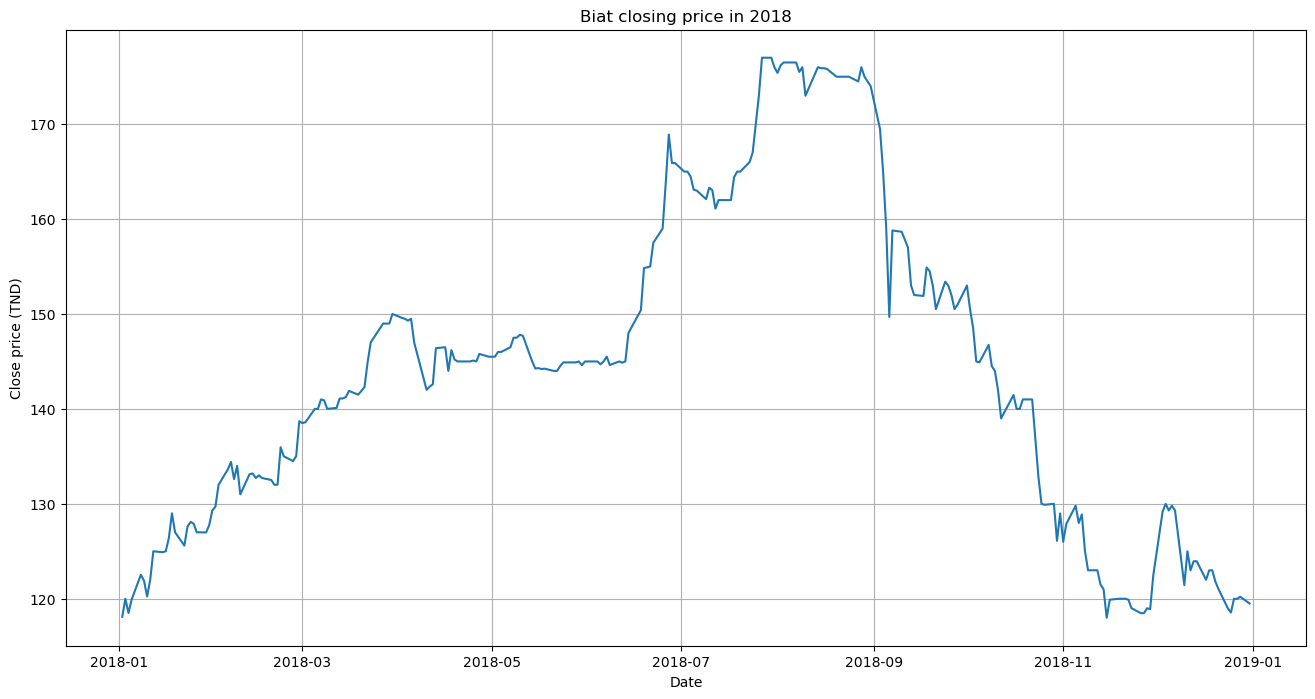

In [114]:
plt.figure(figsize=(16,8))
plt.plot(prices.index, prices['BIAT'])
plt.ylabel('Close price (TND)')
plt.xlabel('Date')
plt.title('Biat closing price in 2018')
plt.grid(True)
plt.show()

More than one stock (you can iterate on whatever stocks you need to visualize)

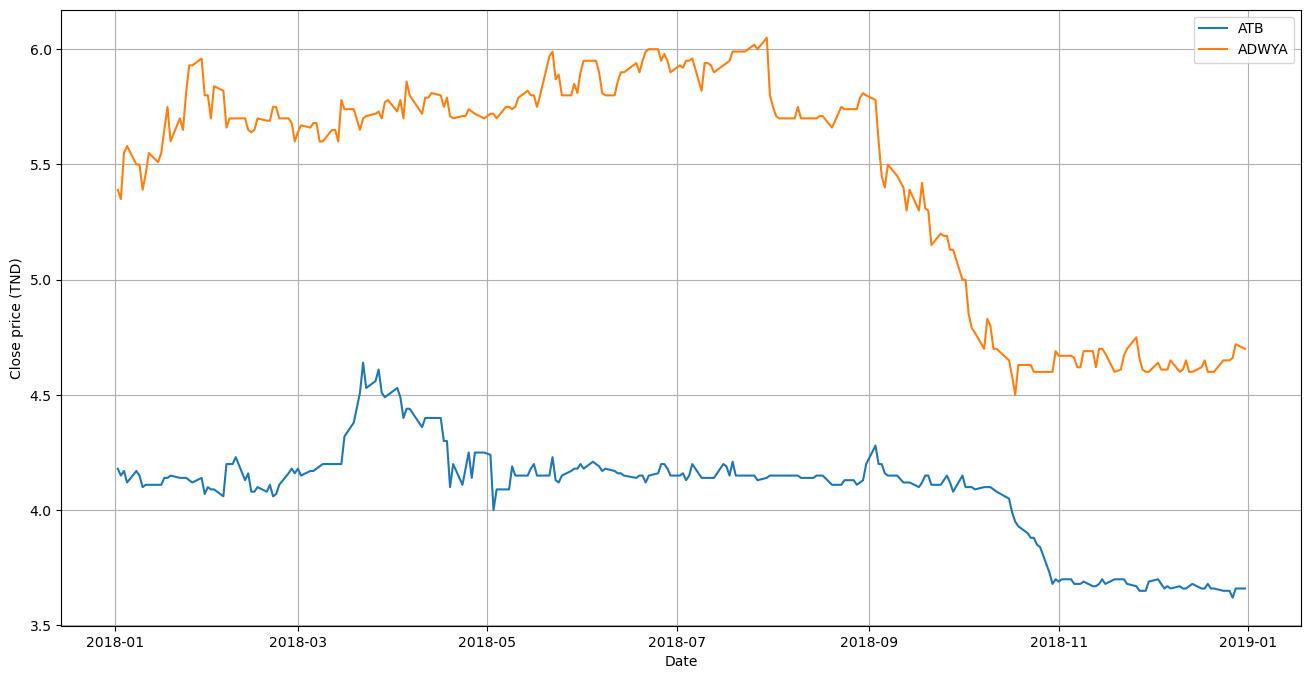

In [115]:
aux = ['ATB', 'ADWYA']
plt.figure(figsize=(16,8))
for col in aux:
    plt.plot(prices.index, prices[col], label=col)
plt.ylabel('Close price (TND)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()


### Calculating stock basic returns

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$


In [116]:
returns = prices.pct_change()

In [117]:
returns.head()

,ADWYA,AETECH,AIR LIQUIDE TSIE,ALKIMIA,AMEN BANK,AMS,ARTES,ASSAD,ASTREE,ATB,...,TUNINVEST-SICAR,TUNIS RE,TUNISAIR,TUNISIE LEASING F,TUNISIE VALEURS,UADH,UBCI,UIB,UNIMED,WIFACK INT BANK
SEANCE,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.007421,0.039216,0.000000,0.000000,-0.000417,-0.025424,0.024590,-0.001111,0.0,-0.007177,...,0.000000,-0.017857,-0.023256,0.047791,NaN,0.004082,0.0,0.004089,0.019108,-0.002692
2018-01-04,0.037383,0.037736,-0.011236,-0.029989,-0.003752,0.000000,0.001600,0.011123,0.0,0.004819,...,0.000000,0.030303,0.023810,-0.000691,NaN,0.056911,0.0,-0.004525,-0.002500,-0.029690
2018-01-05,0.005405,0.018182,0.002273,-0.044929,0.003347,0.000000,0.000000,0.012101,0.0,-0.011990,...,0.029231,-0.012941,-0.023256,0.000000,NaN,0.034615,0.0,0.000000,0.002506,-0.001391
2018-01-08,-0.014337,0.035714,0.000000,-0.023288,0.000000,0.000000,-0.025559,0.016304,0.0,0.012136,...,0.000000,-0.021454,-0.023810,0.000000,NaN,-0.014870,0.0,0.020000,0.025000,0.029248


By using the pandas.pct_change() function, we can easily calculate daily stock returns. It is important to note that this method results in the loss of the first observation, since the percentage change requires a previous data point for the calculation.

This is something to keep in mind when analyzing a specific time period: if you want to retain all observations, you may need to include an extra initial data point to avoid losing the first return value.

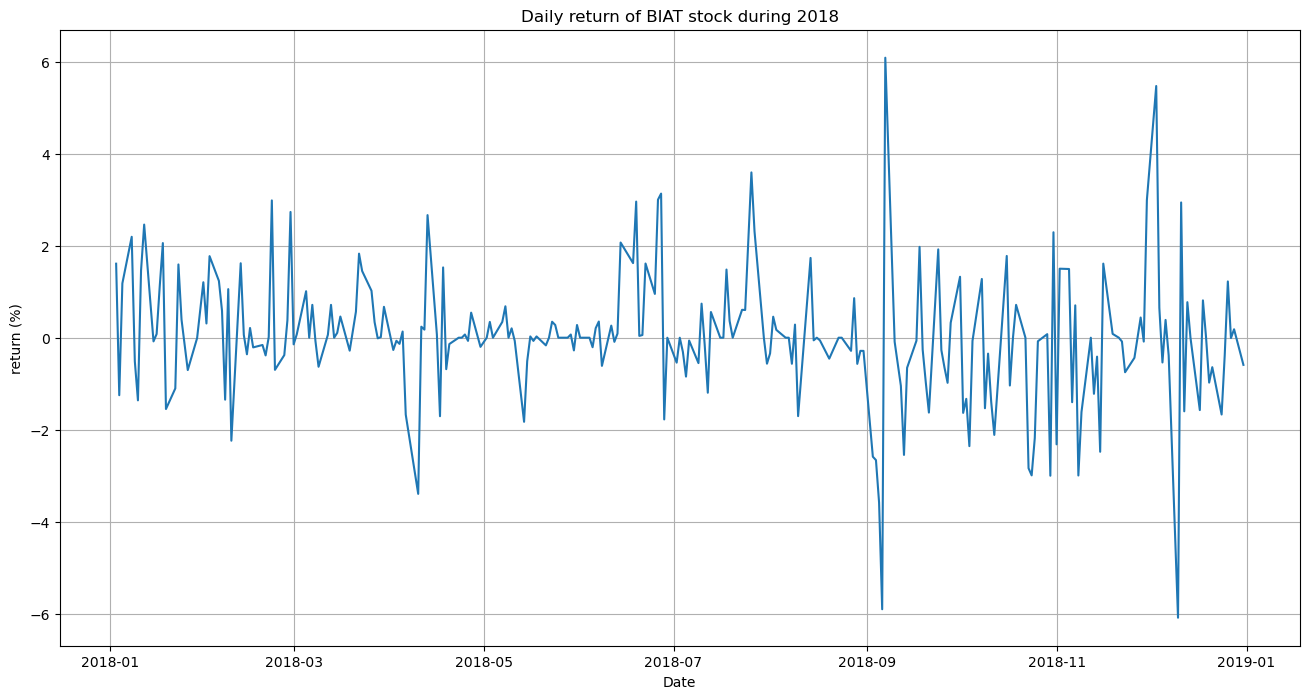

In [118]:
plt.figure(figsize=(16,8))
plt.plot(returns.index, returns['BIAT']*100)
plt.xlabel('Date')
plt.ylabel('return (%)')
plt.title('Daily return of BIAT stock during 2018')
plt.grid(True)
plt.show()

In [119]:
st = ['AMEN BANK', 'BIAT', 'UIB', 'ATB']
returns[st].mean() # expected value

AMEN BANK    0.000645
BIAT         0.000149
UIB          0.000384
ATB         -0.000482
dtype: float64

In [120]:
returns[st].std() # volatility

AMEN BANK    0.010215
BIAT         0.014250
UIB          0.014377
ATB          0.010314
dtype: float64

In [121]:
returns[st].corr() # correlation

,AMEN BANK,BIAT,UIB,ATB
AMEN BANK,1.000000,0.156558,0.273743,0.067039
BIAT,0.156558,1.000000,0.524171,0.118144
UIB,0.273743,0.524171,1.000000,0.139358
ATB,0.067039,0.118144,0.139358,1.000000


Now that we have successfully handled the raw BVMT data and generated a clean, well-structured dataset, we can easily perform further analyses and calculations. For example, we can compute annualized returns, estimate volatility, calculate correlations, or apply more advanced financial models. Having a standardized dataset makes these operations straightforward and ensures that the results are reliable.

## Handling Missing Data

In [122]:
prices.isna().sum() # number of missing values per stock

ADWYA               0
AETECH              0
AIR LIQUIDE TSIE    0
ALKIMIA             0
AMEN BANK           0
                   ..
UADH                0
UBCI                0
UIB                 0
UNIMED              0
WIFACK INT BANK     0
Length: 82, dtype: int64

In [126]:
print(prices.isna().sum().sum()) # number of total missing values in our dataframe

180



Filling missing data is one of the more challenging tasks in financial data analysis because it requires understanding the underlying reasons for the gaps. Simply filling in missing values without understanding the cause can significantly degrade the quality of your dataset.

For example:

- Some stocks may be introduced to the market after the start of the year. Using backward fill in such cases would assign prices to a stock before it actually existed, compromising the validity of your sample.
- Similarly, using forward fill for stocks that have been delisted would assign prices after they were no longer traded, again introducing inaccuracies.

One way to address this is to maintain a separate DataFrame containing the introduction and delisting dates (if applicable) for each stock. Missing values can then be filled only within these valid time intervals.

Additionally, due to the relatively lower data quality in BVMT datasets, zero prices may sometimes appear accidentally. These zeros can create unreliable data points. When working with monthly frequency, a good approach is to aggregate prices using a function that captures the last non-zero price for month-end frequency (ME) or the first non-zero price for month-start frequency (MS). This ensures that missing monthly prices do not distort your analysis.


